/tmp/ipykernel_35317/2643809860.py:38: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Xeint[i,:] = [sol.x, interface(sol.x)]


    fjac: array([[-1.]])
     fun: array([-8.32667268e-17])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([2.18122742e-12])
       r: array([1.25])
  status: 1
 success: True
       x: array([0.8])
    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([-4.36228831e-12])
       r: array([2.75])
  status: 1
 success: True
       x: array([-0.72727273])


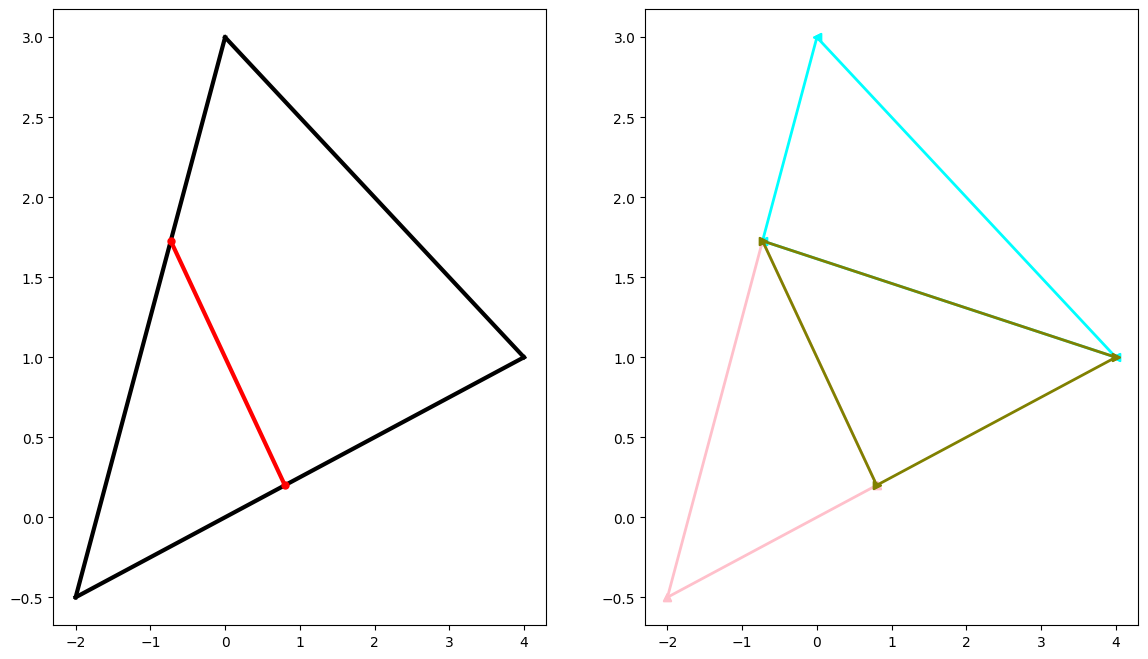

In [1]:
from ShapeFunctions import *
from GaussQuadrature import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, integrate

# DEFINE RANDOM ELEMENT
n = 3
ElType = 0
ElOrder = 1
#Xe = np.array([[-1, -1],[2,0],[0,3]])
Xe = np.array([[-2, -0.5],[4,1],[0,3]])
#Xe = np.array([[0,0],[2,0],[0,2]])
Te = np.array([0,1,2])


##############################################################
# COMPUTE INTERFACE LINEAR APPROXIMATION
def interface(r):
    z = -r+1
    return z

def zedge(r,Xe,edge):
    # FUNCTION DESCRIBING THE RESTRICCION ASSOCIATED TO THE ELEMENT EDGE
    z = ((Xe[edge,1]-Xe[0,1])*r+Xe[0,1]*Xe[edge,0]-Xe[edge,1]*Xe[0,0])/(Xe[edge,0]-Xe[0,0])
    return z

def fun(r,Xe,edge):
    f = interface(r) - zedge(r,Xe,edge)
    return f

# FIND INTERSECTION BETWEEN INTERFACE AND EDGES
Xeint = np.zeros([2,2])
for i, edge in enumerate([1,2]):
    #r0 = 0.5
    r0 = 0
    sol = optimize.root(fun, r0 , args=(Xe,edge))
    Xeint[i,:] = [sol.x, interface(sol.x)]
    print(sol)
    
##############################################################
# PERFORM TESSELLATION

# MODIFIED NODAL MATRIX AND CONECTIVITIES, ACCOUNTING FOR 3 SUBTRIANGLES 
Xemod = np.concatenate((Xe, Xeint), axis=0)
Temod = np.zeros([3, 3], dtype = int)  # connectivities for 3 subtriangles

Temod[0,:] = [0, 3, 4]  # first triangular subdomain is common node and intersection nodes

# COMPARE DISTANCE INTERFACE-(EDGE NODE)
edge = 1
distance1 = np.linalg.norm(Xeint[edge-1,:]-Xe[edge,:])
edge = 2
distance2 = np.linalg.norm(Xeint[edge-1,:]-Xe[edge,:])

if distance1 <= distance2:
    Temod[1,:] = [3, 1, 2]
    Temod[2,:] = [3, 4, 2]
if distance1 > distance2:
    Temod[1,:] = [4, 2, 1]
    Temod[2,:] = [4, 3, 1]

    

fig, axs = plt.subplots(1, 2, figsize=(14,8))
# PLOT IN PHYSICAL SPACE
for i in range(n):
    axs[0].plot([Xe[int(Te[i])-1,0], Xe[int(Te[int((i+1)%n)])-1,0]], 
            [Xe[int(Te[i])-1,1], Xe[int(Te[int((i+1)%n)])-1,1]], color='black', linewidth=3)
      
# PLOT INTERFACE LINEAR APPROXIMATION
axs[0].plot(Xeint[:,0], Xeint[:,1], '.', color='red',markersize=10)
axs[0].plot(Xeint[:,0], Xeint[:,1],color='red', linewidth=3)


# PLOT TRIANGULAR SUBDOMAINS
colorlist = ['pink', 'cyan', 'olive']
markerlist = ['^', '<', '>']
for i in range(3):  # for each subdomain
    for j in range(n):   # plot edges
        plt.plot([Xemod[Temod[i,j],0], Xemod[Temod[i,int((j+1)%n)],0]], [Xemod[Temod[i,j],1], Xemod[Temod[i,int((j+1)%n)],1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])



In [2]:
# COMPUTE AREA OF TRIANGLES:

def Area(Xe):
    edge1 = np.linalg.norm(Xe[0,:]-Xe[1,:])
    edge2 = np.linalg.norm(Xe[1,:]-Xe[2,:])
    edge3 = np.linalg.norm(Xe[2,:]-Xe[0,:])
    s = (edge1 + edge2 + edge3)/2
    area = (s*(s-edge1)*(s-edge2)*(s-edge3)) ** 0.5
    return area

Totalarea = Area(Xe)
print(Totalarea)

area1 = Area(Xemod[Temod[0,:]])
area2 = Area(Xemod[Temod[1,:]])
area3 = Area(Xemod[Temod[2,:]])

print(area1)
print(area2)
print(area3)
print(area1+area2+area3)

9.0
2.6727272727272724
3.2727272727272725
3.0545454545454587
9.000000000000004


In [3]:
# VERIFY QUADRATURE FOR SUBDOMAINS INTEGRATION
# THAT IS, WE NEED TO VERIFY THAT INTEGRATING IN THE 3 SUBDOMAINS SEPARATELY IS EQUIVALENT TO INTEGRATING IN THE WHOLE DOMAIN (WHEN INTEGRATING THE SAME FUNCTION)

def source(r,z):
    # SOURCE FUNCTION IN THE ELEMENT TO INTEGRATE. IF SOURCE = 1, THE EXPECTED RESULT IS THE AREA OF THE ELEMENT
    # return r**2+z**2
    return 1
    

def InverseMapping(X, Xe, ElType, ElOrder, n):
    """ This function represents the inverse mapping corresponding to the transformation from natural to physical coordinates. 
    That is, given a point in physical space with coordinates X in the specified element, this function returns the point mapped
    in the natural reference frame with coordinates Xg. 
    In order to do that, we solve the nonlinear system implicitly araising from the original isoparametric mapping equations. """
    
    # DEFINE THE NONLINEAR SYSTEM 
    def fun(Xg, X, Xe):
        f = np.array([-X[0],-X[1]])
        for i in range(n):
            Nig, foo, foo = ShapeFunctionsReference(Xg,ElType, ElOrder, i+1)
            f[0] += Nig*Xe[i,0]
            f[1] += Nig*Xe[i,1]
        return f
    # SOLVE USING NONLINEAR SOLVER
    Xg0 = np.array([1/2, 1/2])  # INITIAL GUESS FOR ROOT SOLVER
    sol = optimize.root(fun, Xg0, args=(X,Xe))
    Xg = sol.x
    return Xg
    

QuadratureOrder = 2
#### QUADRATURE TO INTEGRATE SURFACES (2D)
z, w, Ng = GaussQuadrature(ElType,QuadratureOrder)
N, dNdxi, dNdeta = EvaluateShapeFunctions(ElType, ElOrder, n, z)

#### INTEGRATION ON FULL DOMAIN
fe = np.zeros([n])
# LOOP OVER GAUSS NODES
for ig in range(Ng):
    # MAPP GAUSS NODAL COORDINATES FROM NATURAL TO PHYSICAL SYSTEM OF REFERENCE
    Xg = N[ig,:] @ Xe
    invJ, detJ = Jacobian(Xe[:,0],Xe[:,1],dNdxi[ig,:],dNdeta[ig,:])
    # COMPUTE ELEMENTAL CONTRIBUTIONS AND ASSEMBLE GLOBAL SYSTEM 
    for i in range(n):   # ROWS ELEMENTAL MATRIX
        fe[i] += N[ig,i] * source(Xg[0],Xg[1]) * detJ * w[ig]
        
        
#### INTEGRATION ON SUBDOMAINS USING INVERSE MAPPING TO COMPUTE MODIFIED QUADRATURE
fek = np.zeros([n,n])
for k in range(len(Temod[:,0])):
    Tek = Temod[k,:]
    Xek = Xemod[Tek,:]
    # LOOP OVER GAUSS NODES
    for ig in range(Ng):
        # MAPP GAUSS NODAL COORDINATES FROM NATURAL TO PHYSICAL SYSTEM OF REFERENCE
        Xg = N[ig,:] @ Xek
        invJ, detJ = Jacobian(Xek[:,0],Xek[:,1],dNdxi[ig,:],dNdeta[ig,:]) 
        # COMPUTE MODIFIED QUADRATURE
        Xgk = InverseMapping(Xg, Xe, ElType, ElOrder, n)
        # COMPUTE ELEMENTAL CONTRIBUTIONS AND ASSEMBLE GLOBAL SYSTEM 
        for i in range(n):   # ROWS ELEMENTAL MATRIX
            # EVALUATE SHAPE FUNCTION IN MODIFIED QUADRATURE
            Nk, foo, foo = ShapeFunctionsReference(Xgk, ElType, ElOrder, i+1)
            fek[k,i] += Nk * source(Xg[0],Xg[1]) * np.abs(detJ) * w[ig]
    
print(fe)
print(sum(fe))


print(sum(fek[0,:]))
print(sum(fek[1,:]))
print(sum(fek[2,:]))
print(sum(sum(fek)))


[3. 3. 3.]
8.999999999999996
2.672727272727273
3.272727272727273
3.0545454545454547
9.0


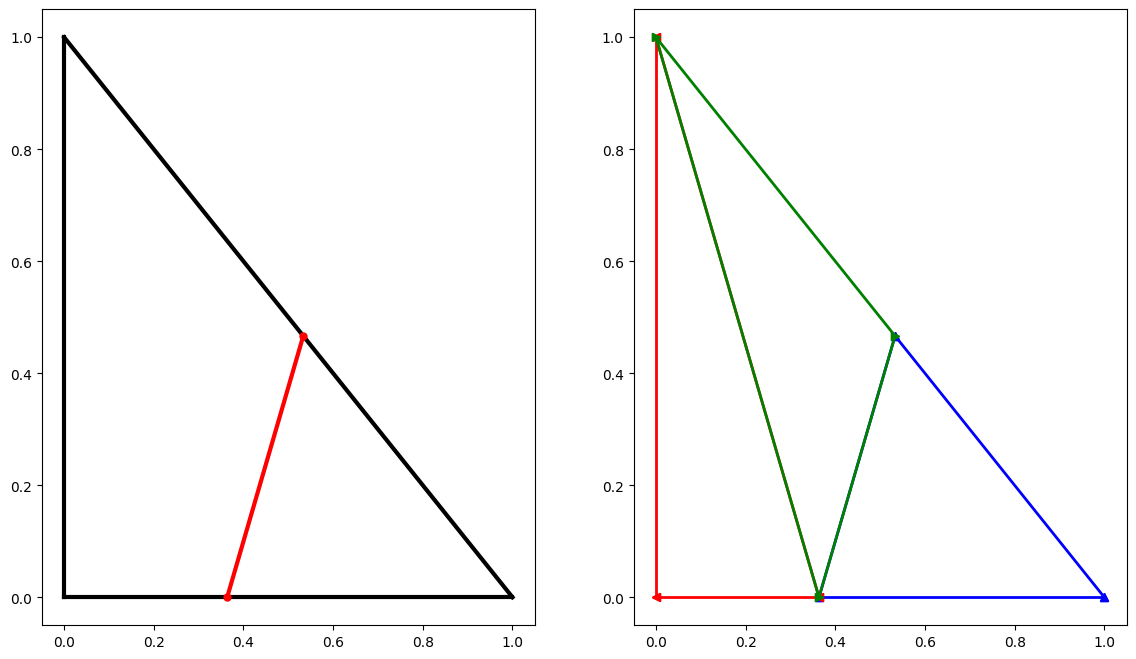

In [4]:
# IT IS COMPUTATIONALLY MORE EFFICIENT TO MAP THE INTERSECTION POINTS TO THE REFERENCE DOMAIN AND PERFORM THE TESSALLATION THERE. ONCE THE 
# ELEMENT HAS BEEN SUBDIVIDED, THE MODIFIED QUADRATURE (INTEGRATION POINTS) CAN BE COMPUTED, WHERE THE SHAPE FUNCTIONS WILL BE EVALUATED. 

XeREF = np.array([[1,0], [0,0], [0,1]])
TeREF = np.array([0, 1, 2])
XeintREF = np.zeros([2,2])
for i in range(2):
    XeintREF[i,:] = InverseMapping(Xeint[i,:], Xe, ElType, ElOrder, n)

##############################################################
# PERFORM TESSELLATION
XeintREF = XeintREF[[1,0],:]

# MODIFIED NODAL MATRIX AND CONECTIVITIES, ACCOUNTING FOR 3 SUBTRIANGLES 
XeREFmod = np.concatenate((XeREF, XeintREF), axis=0)

TeREFmod = np.zeros([3, n], dtype = int)  # connectivities for 3 subtriangles

TeREFmod[0,:] = [0, 3, 4]  # first triangular subdomain is common node and intersection nodes

# COMPARE DISTANCE INTERFACE-(EDGE NODE)
edge = 1
distance1 = np.linalg.norm(XeintREF[edge-1,:]-XeREF[edge,:])
edge = 2
distance2 = np.linalg.norm(XeintREF[edge-1,:]-XeREF[edge,:])

if distance1 < distance2:
    TeREFmod[1,:] = [3, 1, 2]
    TeREFmod[2,:] = [3, 4, 2]
if distance1 > distance2:
    TeREFmod[1,:] = [4, 2, 1]
    TeREFmod[2,:] = [4, 3, 1]


#### PLOT
fig, axs = plt.subplots(1, 2, figsize=(14,8))
# PLOT IN PHYSICAL SPACE
for i in range(n):
    axs[0].plot([XeREF[int(TeREF[i])-1,0], XeREF[int(TeREF[int((i+1)%n)])-1,0]], 
            [XeREF[int(TeREF[i])-1,1], XeREF[int(TeREF[int((i+1)%n)])-1,1]], color='black', linewidth=3)
      
# PLOT INTERFACE LINEAR APPROXIMATION
axs[0].plot(XeintREF[:,0], XeintREF[:,1], '.', color='red',markersize=10)
axs[0].plot(XeintREF[:,0], XeintREF[:,1],color='red', linewidth=3)


# PLOT TRIANGULAR SUBDOMAINS
colorlist = ['blue', 'red', 'green']
markerlist = ['^', '<', '>']
for i in range(3):  # for each subdomain
    for j in range(n):   # plot edges
        plt.plot([XeREFmod[TeREFmod[i,j],0], XeREFmod[TeREFmod[i,int((j+1)%n)],0]], [XeREFmod[TeREFmod[i,j],1], XeREFmod[TeREFmod[i,int((j+1)%n)],1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])

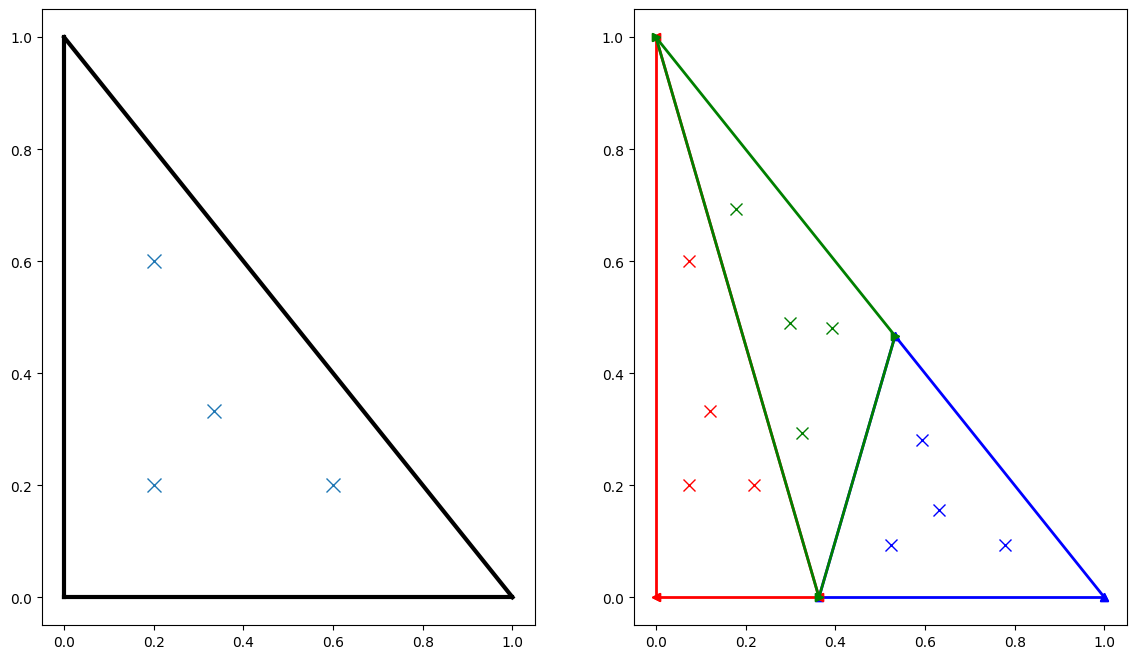

In [5]:
QuadratureOrder = 3
#### QUADRATURE TO INTEGRATE SURFACES (2D)
z, w, Ng = GaussQuadrature(ElType,QuadratureOrder)
N, dNdxi, dNdeta = EvaluateShapeFunctions(ElType, ElOrder, n, z)

## COMPUTE GAUSS INTEGRATION NODES ON SUBELEMENTS IN REFERENCE DOMAIN
XgREFmod = np.zeros([3*Ng,2])
for i in range(3):
    for ig in range(Ng):
        XgREFmod[Ng*i+ig,:] = N[ig,:] @ XeREFmod[TeREFmod[i,:]]

#### PLOT
fig, axs = plt.subplots(1, 2, figsize=(14,8))
# PLOT IN PHYSICAL SPACE
for i in range(n):
    axs[0].plot([XeREF[int(TeREF[i])-1,0], XeREF[int(TeREF[int((i+1)%n)])-1,0]], 
            [XeREF[int(TeREF[i])-1,1], XeREF[int(TeREF[int((i+1)%n)])-1,1]], color='black', linewidth=3)
axs[0].plot(z[:,0],z[:,1],'x', markersize = 10)

# PLOT TRIANGULAR SUBDOMAINS
colorlist = ['blue', 'red', 'green']
markerlist = ['^', '<', '>']
for i in range(3):  # for each subdomain
    for j in range(n):   # plot edges
        plt.plot([XeREFmod[TeREFmod[i,j],0], XeREFmod[TeREFmod[i,int((j+1)%n)],0]], [XeREFmod[TeREFmod[i,j],1], XeREFmod[TeREFmod[i,int((j+1)%n)],1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])
    axs[1].plot(XgREFmod[Ng*i:Ng*(i+1),0],XgREFmod[Ng*i:Ng*(i+1),1],'x',color=colorlist[i], markersize = 8)

In [25]:
#### INTEGRATION ON SUBDOMAINS USING MODIFIED QUADRATURE COMPUTED FROM TESSELLATION IN REFERENCE DOMAIN AND EVALUATING JACOBIAN ON MODIFIED GAUSS NODES
fekk = np.zeros([n,n])
for k in range(len(Temod[:,0])):
    Tek = Temod[k,:]
    Xek = Xemod[Tek,:]
    # USE MODIFIED QUADRATURE ON REFERENCE DOMAIN
    XgREFk = XgREFmod[Ng*k:Ng*(k+1),:]
    # EVALUATE REFERENCE SHAPE FUNCTIONS IN MODIFIED QUADRATURE
    N, dNdxi, dNdeta = EvaluateShapeFunctions(ElType, ElOrder, n, XgREFk)
    # LOOP OVER GAUSS NODES
    for ig in range(Ng):
        # MAPP GAUSS NODAL COORDINATES FROM NATURAL TO PHYSICAL SYSTEM OF REFERENCE
        Xgk = N[ig,:] @ Xek
        invJ, detJ = Jacobian(Xek[:,0],Xek[:,1],dNdxi[ig,:],dNdeta[ig,:])
        # COMPUTE ELEMENTAL CONTRIBUTIONS AND ASSEMBLE GLOBAL SYSTEM 
        for i in range(n):   # ROWS ELEMENTAL MATRIX
            # EVALUATE SHAPE FUNCTION IN MODIFIED QUADRATURE
            Nk, foo, foo = ShapeFunctionsReference(XgREFk[ig,:], ElType, ElOrder, i+1)
            fekk[k,i] += Nk * source(Xgk[0],Xgk[1]) * np.abs(detJ) * w[ig]

print('Integration on whole element')
print(fe)
print(sum(fe))

print("Integration on subelements computing modified quadrature with inverse mapping for each gaus node")
print(sum(fek[0,:]))
print(sum(fek[1,:]))
print(sum(fek[2,:]))
print(sum(sum(fek)))           
            
print("Integration on subelements computing modified quadrature by performing tessellation on reference domain")
print(sum(fekk[0,:]))
print(sum(fekk[1,:]))
print(sum(fekk[2,:]))
print(sum(sum(fekk)))

Integration on whole element
[3. 3. 3.]
8.999999999999996
Integration on subelements computing modified quadrature with inverse mapping for each gaus node
2.672727272727273
3.272727272727273
3.0545454545454547
9.0
Integration on subelements computing modified quadrature by performing tessellation on reference domain
2.672727272727273
3.2727272727272725
3.0545454545454547
9.0


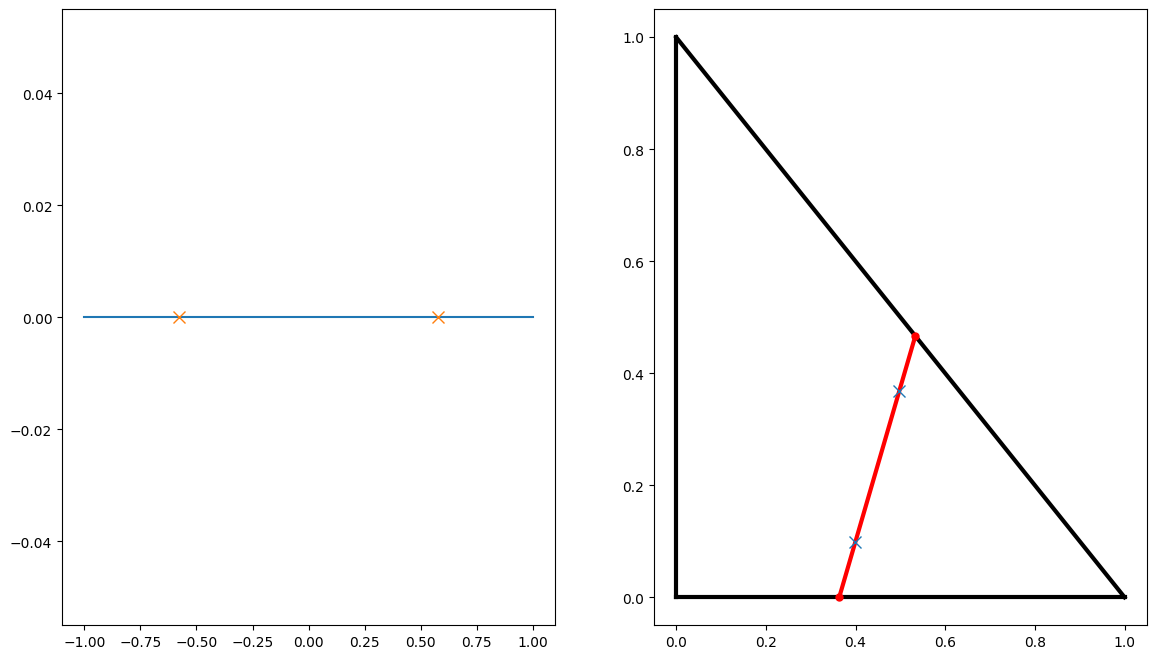

In [8]:
# VERIFY QUADRATURE FOR INTERFACE INTEGRATION

#### QUADRATURE TO INTEGRATE LINES (1D)
QuadratureOrder = 2
zline, wline, Ngline = GaussQuadrature(2,QuadratureOrder)
nline = 2
Nline, dNdxiline, foo = EvaluateShapeFunctions(2, nline-1, nline, zline)

# COMPUTE GAUSS INTEGRATION NODES ON SUBELEMENTS IN REFERENCE DOMAIN
XgintREF = np.zeros([Ngline,2])
for ig in range(Ngline):
    XgintREF[ig,:] = Nline[ig,:] @ XeintREF

#### PLOT
fig, axs = plt.subplots(1, 2, figsize=(14,8))
# PLOT IN REFERENCE SPACE

axs[0].plot([-1,1],[0,0])
axs[0].plot(zline,np.zeros([Ngline]),'x', markersize = 8)

for i in range(n):
    axs[1].plot([XeREF[int(TeREF[i])-1,0], XeREF[int(TeREF[int((i+1)%n)])-1,0]], 
            [XeREF[int(TeREF[i])-1,1], XeREF[int(TeREF[int((i+1)%n)])-1,1]], color='black', linewidth=3)
      
# PLOT INTERFACE LINEAR APPROXIMATION
axs[1].plot(XeintREF[:,0], XeintREF[:,1], '.', color='red',markersize=10)
axs[1].plot(XeintREF[:,0], XeintREF[:,1],color='red', linewidth=3)
axs[1].plot(XgintREF[:,0],XgintREF[:,1],'x', markersize = 8)


In [9]:
print("zline",zline)
print("wline",wline)
print("Nline",Nline)
print("dNdxiline",dNdxiline)

print("XeintREF",XeintREF)

print("XgintREF",XgintREF)


zline [[-0.57735027]
 [ 0.57735027]]
wline [1. 1.]
Nline [[0.78867513 0.21132487]
 [0.21132487 0.78867513]]
dNdxiline [[-0.5  0.5]
 [-0.5  0.5]]
XeintREF [[ 3.63636364e-01 -3.08395285e-17]
 [ 5.33333333e-01  4.66666667e-01]]
XgintREF [[0.39949755 0.09861827]
 [0.49747214 0.3680484 ]]


In [15]:
# COMPUTE INTEGRAL USING ADAPTED GAUSS QUADRATURE

def fun(z):
    return 1

####### SUMMARY
### 1D REFERENCE ELEMENT:
#   zline: GAUSS NODAL COORDINATES IN 1D REFERENCE ELEMENT
#   wline: GAUSS WEIGHTS IN 1D REFERENCE ELEMENT
### 2D REFERENCE ELEMENT:
#   XeREF: NODAL COORDINATES OF 2D REFERENCE ELEMENT
#   XeintREF: NODAL COORDINATES OF INTERFACE IN 2D REFERENCE ELEMENT
#   XgintREF: GAUSS NODAL COORDINATES IN 2D REFERENCE ELEMENT
### 2D PHYSICAL ELEMENT:
#   Xe: NODAL COORDINATES OF 2D PHYSICAL ELEMENT 
#   Xeint: NODAL COORDINATES OF INTERFACE IN 2D PHYSICAL ELEMENT
#   Xgint: GAUSS NODAL COORDINATES IN 2D PHYSICAL ELEMENT

# EVALUATE 1D REFERENCE SHAPE FUNCTIONS ON 1D REFERENCE GAUS NODES
Nline, dNdxiline, foo = EvaluateShapeFunctions(2, nline-1, nline, zline)

# EVALUATE 2D REFERENCE SHAPE FUNCTIONS ON MODIFIED 1D REFERENCE GAUSS NODES
Nmod, dNdximod, dNdetamod = EvaluateShapeFunctions(ElType, ElOrder, n, XgintREF)

# VERIFY INTEGRAL OF IDENTITY FUNCTION RETURNS LENGTH OF INTERFACE SEGMENT
length = 0
for ig in range(Ngline):
    # MAPP GAUSS NODAL COORDINATES FROM NATURAL TO PHYSICAL SYSTEM OF REFERENCE
    Xgint = Nline[ig,:] @ Xeint
    # COMPUTE JACOBIAN OF TOTAL TRANSFORMATION
    detJline = Jacobian1D(Xeint[:,0],Xeint[:,1],dNdxiline[ig,:])
    # COMPUTE INTEGRAL
    length += fun(Xgint) * np.abs(detJline) * wline[ig]

print(np.linalg.norm(Xeint[0,:]-Xeint[1,:]))

print(length)



2.159889804351636
2.159889804351636


In [14]:


fekline = np.zeros([n])
for ig in range(Ngline):
    # MAPP GAUSS NODAL COORDINATES FROM NATURAL TO PHYSICAL SYSTEM OF REFERENCE
    Xgint = Nline[ig,:] @ Xeint
    # COMPUTE JACOBIAN OF TOTAL TRANSFORMATION
    detJline = Jacobian1D(Xeint[:,0],Xeint[:,1],dNdxiline[ig,:])

    for i in range(n):   
        # EVALUATE SHAPE FUNCTION IN MODIFIED QUADRATURE
        Nk, foo, foo = ShapeFunctionsReference(XgintREF[ig,:], ElType, ElOrder, i+1)
        fekline[i] += Nk * source(Xgint[0],Xgint[1]) * np.abs(detJline) * wline[ig]

print(fekline)


[0.96867785 0.50397429 0.68723767]
